#### Copyright 2020 Google LLC.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Video Classification with Pre-Trained Models Project

In this project we will import a pre-existing model that recognizes objects and use the model to identify those objects in a video. We'll edit the video to draw boxes around the identified object, and then we'll reassemble the video so the boxes are shown around objects in the video.

##Team Members

1. Jose Martinez
1. Wren Priest
1. Maria Quintero 

# Exercises

## Exercise 1: Coding

You will process a video frame by frame, identify objects in each frame, and draw a bounding box with a label around each car in the video.
 
Use the [SSD MobileNet V1 Coco](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf1_detection_zoo.md) (*ssd_mobilenet_v1_coco*) model. The video you'll process can be found [on Pixabay](https://pixabay.com/videos/cars-motorway-speed-motion-traffic-1900/). The 640x360 version of the video is smallest and easiest to handle, though any size should work since you must scale down the images for processing.
 
Your program should:
 
* Read in a video file (use the one in this colab if you want)
* Load the TensorFlow model linked above
* Loop over each frame of the video
* Scale the frame down to a size the model expects
* Feed the frame to the model
* Loop over detections made by the model
* If the detection score is above some threshold, draw a bounding box onto the frame and put a label in or near the box
* Write the frame back to a new video
 
Some tips:
 
* Processing an entire video is slow, so consider truncating the video or skipping over frames during development. Skipping frames will make the video choppy. But you'll be able to see a wider variety of images than you would with a truncated video with all of the original frames in the clip.
* The model expects a 300x300 image. You'll likely have to scale your frames to fit the model. When you get a bounding box, that box is relative to the scaled image. You'll need to scale the bounding box out to the original image size.
* Don't start by trying to process the video. Instead, capture one frame and work with it until you are happy with your object detection, bounding boxes, and labels. Once you get those done, use the same logic on the other frames of the video.
* The [Coco labels file](https://github.com/nightrome/cocostuff/blob/master/labels.txt) can be used to identify classified objects.
 

### **Student Solution**

#### Initial Importing and Setup

In [ ]:
import urllib.request
import os

base_url = 'http://download.tensorflow.org/models/object_detection/'
file_name = 'ssd_mobilenet_v1_coco_2018_01_28.tar.gz'

url = base_url + file_name

urllib.request.urlretrieve(url, file_name)

import tarfile
import shutil

dir_name = file_name[0:-len('.tar.gz')]

if os.path.exists(dir_name):
  shutil.rmtree(dir_name) 

tarfile.open(file_name, 'r:gz').extractall('./')

os.listdir(dir_name)

import tensorflow as tf

frozen_graph = os.path.join(dir_name, 'frozen_inference_graph.pb')

with tf.io.gfile.GFile(frozen_graph, "rb") as f:
  graph_def = tf.compat.v1.GraphDef()
  loaded = graph_def.ParseFromString(f.read())

outputs = (
  'num_detections:0',
  'detection_classes:0',
  'detection_scores:0',
  'detection_boxes:0',
)

def wrap_graph(graph_def, inputs, outputs, print_graph=False):
  wrapped = tf.compat.v1.wrap_function(
    lambda: tf.compat.v1.import_graph_def(graph_def, name=""), [])

  return wrapped.prune(
    tf.nest.map_structure(wrapped.graph.as_graph_element, inputs),
    tf.nest.map_structure(wrapped.graph.as_graph_element, outputs))
    
model = wrap_graph(graph_def=graph_def,
                   inputs=["image_tensor:0"],
                   outputs=outputs)


In [ ]:
# Object detection dictionary
labels = {
    0:"background",
    1:"person",
    2:"bicycle",
    3:"car",
    4:"motorcycle",
    5:"airplane",
    6:"bus",
    7:"train",
    8:"truck",
    9:"boat",
    10:"trafficlight",
    11:"firehydrant",
    12:"unknown",
    13:"stopsign",
    14:"parkingmeter",
    15:"bench",
    16:"bird",
    17:"cat",
    18:"dog",
    19:"horse",
    20:"sheep",
    21:"cow",
    22:"elephant",
    23:"bear",
    24:"zebra",
    25:"giraffe",
    26:"unknown",
    27:"backpack",
    28:"umbrella",
    29:"unknown",
    30:"unknown",
    31:"handbag",
    32:"tie",
    33:"suitcase",
    34:"frisbee",
    35:"skis",
    36:"snowboard",
    37:"sportsball",
    38:"kite",
    39:"baseballbat",
    40:"baseballglove",
    41:"skateboard",
    42:"surfboard",
    43:"tennisracket",
    44:"bottle",
    45:"unknown",
    46:"wineglass",
    47:"cup",
    48:"fork",
    49:"knife",
    50:"spoon",
    51:"bowl",
    52:"banana",
    53:"apple",
    54:"sandwich",
    55:"orange",
    56:"broccoli",
    57:"carrot",
    58:"hotdog",
    59:"pizza",
    60:"donut",
    61:"cake",
    62:"chair",
    63:"couch",
    64:"pottedplant",
    65:"bed",
    66:"unknown",
    67:"diningtable",
    68:"unknown",
    69:"unknown",
    70:"toilet",
    71:"unknown",
    72:"tv",
    73:"laptop",
    74:"mouse",
    75:"remote",
    76:"keyboard",
    77:"cellphone",
    78:"microwave",
    79:"oven",
    80:"toaster",
    81:"sink",
    82:"refrigerator",
    83:"unknown",
    84:"book",
    85:"clock",
    86:"vase",
    87:"scissors",
    88:"teddybear",
    89:"hairdrier",
    90:"toothbrush"
}

#### Data Preprocessing

In [ ]:
import cv2

# import video
cars_video = cv2.VideoCapture("cars.mp4")
# get video properties and store as variables
height = int(cars_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(cars_video.get(cv2.CAP_PROP_FRAME_WIDTH))
fps = cars_video.get(cv2.CAP_PROP_FPS)
total_frames = int(cars_video.get(cv2.CAP_PROP_FRAME_COUNT))

# print video properties
print(f'height: {height}')
print(f'width: {width}')
print(f'frames per second: {fps}')
print(f'total frames: {total_frames}')
print(f'video length (seconds): {total_frames / fps}')

# determine how much padding is needed to get to 300 by 300
left_pad, right_pad, top_pad, bottom_pad = 0, 0, 0, 0
if height > width:
  left_pad = int((height-width) / 2)
  right_pad = height-width-left_pad
elif width > height:
  top_pad = int((width-height) / 2)
  bottom_pad = width-height-top_pad

# pads cars.mp4 and outputs padded.mp4
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
input_video = cv2.VideoCapture("cars.mp4")
output_video = cv2.VideoWriter('padded.mp4', fourcc, fps, (width + left_pad + right_pad, height + top_pad + bottom_pad))
for i in range(0, int(total_frames)):
  # progress ticker, will count from 0 to 1501
  print(i, end=" ")
  input_video.set(cv2.CAP_PROP_POS_FRAMES, i)
  ret, frame = input_video.read()
  frame_square = cv2.copyMakeBorder(
        frame,
        top_pad,
        bottom_pad,
        left_pad,
        right_pad,
        cv2.BORDER_CONSTANT,
        value=(255,255,255))
  if not ret:
    raise Exception("Problem reading frame", i, " from video")
  output_video.write(frame_square)

input_video.release()
output_video.release()

# scales padded.mp4 and outputs scaled.mp4
cars_video = cv2.VideoCapture("padded.mp4")
output = cv2.VideoWriter('scaled.mp4', fourcc, 25.0, (300, 300))
while True:
  ret, frame = cars_video.read()
  if ret == True:
    b = cv2.resize(frame,(300,300),fx=0,fy=0)
    output.write(b)
  else:
    break

cars_video.release()
output.release()


height: 360
width: 640
frames per second: 25.0
total frames: 1501
video length (seconds): 60.04
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 25

#### Model Input and Output

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

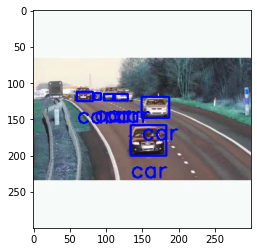

In [ ]:
import matplotlib.pyplot as plt

# set video output parameters
output_video = cv2.VideoWriter('classed.mp4', fourcc, 25.0, (300, 300))

# loop over frames
for i in range(0, total_frames):
  # progress ticker, will count from 0 to 1501
  print(i, end=" ")
  # reading in video frame
  input_video = cv2.VideoCapture('scaled.mp4')
  input_video.set(cv2.CAP_PROP_POS_FRAMES, i)
  ret, frame = input_video.read()
  input_video.release()
  if not ret:
    raise Exception(f"Problem reading frame {i} from video")
  # input_image will be edited while frame is used as a static variable
  input_image = frame
  # convert to tensor for model
  tensor = tf.convert_to_tensor([frame], dtype=tf.uint8)
  # run tensor frame through model
  detections = model(tensor)

  # extract information from model detections
  num_detect = int(detections[0].numpy()[0])
  classes = detections[1].numpy()[0, :num_detect]
  scores = detections[2].numpy()[0, :num_detect]
  boxes = detections[3].numpy()[0, :num_detect]

  # bounding boxes and text labels
  H, W, _ = input_image.shape
  for x in range(num_detect):
      box = boxes[x]
      y1, x1, y2, x2 = box
      x1 *= W 
      x2 *= W 
      y1 *= H
      y2 *= H
      # uses dictionary to map detection number to class name
      label = labels[classes[x]]
      # draw boxes and labels
      cv2.rectangle(input_image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2) 
      cv2.putText(input_image, label, (int(x1), int(y2+30)),
                  cv2.FONT_HERSHEY_SIMPLEX, 1, [0, 0, 255], 2)
      
  # test to be sure model was seeing and classifying frames
  plt.imshow(input_image)

  # write each annotated image into 'classed.mp4'
  output_video.write(input_image)
  
output_video.release()


---

## Exercise 2: Ethical Implications

Even the most basic models have the potential to affect segments of the population in different ways. It is important to consider how your model might positively and negatively affect different types of users.

In this section of the project, you will reflect on the positive and negative implications of your model. Frame the context of your model creation using this narrative:

> The city of Seattle is attempting to reduce traffic congestion in its downtown area. As part of this project, they plan to allow each local driver one free trip to downtown Seattle per week. After that, the driver will have to pay a $50 toll for each extra day per week driven. As an early proof of concept for this project, your team is tasked with using machine learning to correctly identify automobiles on the road. The next phase of the project will involve detecting license plate numbers and then cross-referencing that data with RFID chips that should be mounted in all local drivers' cars.

### **Student Solution**

**Positive Impact**

Your model is trying to solve a problem. Think about who will benefit from that problem being solved and write a brief narrative about how the model will help.

>The model will benefit the city because there will be less traffic, less car accidents, and less pollution. Citizens of the city will avoid driving downtown with a toll. The less traffic flow will also be better for emergency vehicles such as ambulances and fire trucks. Lastly, less traffic will also be better for the environment. 

**Negative Impact**

Models rarely benefit everyone equally. Think about who might be negatively impacted by the predictions your model is making. This person(s) might not be directly using the model, but they might be impacted indirectly.

> Citizens that work in the downtown area will be negatively impacted because the toll will be a financial obstacle for them to get to work. For example Taxis would be especially negatively impacted since they made need to travel in and out of the city constantly.  

**Bias**

Models can be biased for many reasons. The bias can come from the data used to build the model (e.g., sampling, data collection methods, available sources) and/or from the interpretation of the predictions generated by the model.

Think of at least two ways bias might have been introduced to your model and explain both below.

> One source of bias in the model could be data collection bias since not all cars look the same. Some cars such as trucks, trailers, buses, or semi trucks transporting multiple cars can be mistaken in the system. In the case of a car transporting multiple cars, the data would be skewed.  

> Another source of bias could be reporting bias. An example would be vehicles such as buses considered cars. Since buses are public transportation and encourage people to leave their cars at home, the model should not classify busses as a car. 

**Changing the Dataset to Mitigate Bias**

Having bias in your dataset is one of the primary ways in which bias is introduced to a machine learning model. Look back at the input data you fed to your model. Think about how you might change something about the data to reduce bias in your model.

What change or changes could you make to reduce the bias in your dataset? Consider the data you have, how and where it was collected, and what other sources of data might be used to reduce bias.

Write a summary of changes that could be made to your input data.

> To reduce the bias in the dataset, the source of data for the model could be collected from multiple car dealership to reduce the amount of mistake between a car and vehicles such as trucks or trailers. In summary the input data would collect a larger variety of vehicles. 

**Changing the Model to Mitigate Bias**

Is there any way to reduce bias by changing the model itself? This could include modifying algorithmic choices, tweaking hyperparameters, etc.

Write a brief summary of changes you could make to help reduce bias in your model.

>To reduce bias in the model itself, the model could be trained to classify exceptions in the system such as buses or vehicles transporting multiple cars. 



**Mitigating Bias Downstream**

Models make predictions. Downstream processes make decisions. What processes and/or rules should be in place for people and systems interpreting and acting on the results of your model to reduce bias? Describe these rules and/or processes below.

> Since the predictions have potential bias reporting, we can adjust the process of the system to recognize exception adn classify them according to most similar features to another vehicle. 

